# Prepare Resting-State ICA maps

This notebook (1) downloads individual subject ICA component timeseries, and based on this (2) computes individual ICA components (that are aliged across subjects, by virtue of beeing based on the same group components that gave rise to the original component timeseries.


**Inputs**

All 4 HCP resting state runs for each subject <br>
reduced to the left hemisphere: shape 4x (29696, 1200) ~ (29696, 1200) <br>
`$SUBJ/MNINonLinear/Results/$SESSION/${SESSION}_Atlas_MSMAll_hp2000_clean.dtseries.nii`

Indiviudal subject ICA component timeseries, shape (200, 4800) <br>
based on group-level ICA components<br>
`HCP_Resources/GroupAvg/HCP_PTN1200/NodeTimeseries_3T_HCP1200_MSMAll_ICAd200_ts2.tar.gz`<br>
extracting to: `../node_timeseries/3T_HCP1200_MSMAll_d{n_ica_comps}_ts2/{subj}.txt`

**Outputs**

HCP Individual Subject RS-ICA-Components <br>
for 254 Subjects, comps[subj].shape ~ (29696, 200)<br>
`/scratch/users/robert.scholz2/acc_dists/all_ICAmapsV2_254_full_unrelated.L.c200.npy`

<br>

In [1]:
import os
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm
# for making dynamic replacement strings
f= lambda str: eval("f'" + f"{str}" + "'")

import nibabel as nib
nib.imageglobals.logger.setLevel(40)

# Download of required Files

In [5]:
## The NoteTS files are the only files that havent been dowloaded yet
## getting the parcellation timeseries 
from lib.aws_tools import download_aws_file

# node_ts_archive_file = download_aws_file("HCP_Resources/GroupAvg/HCP_PTN1200/NodeTimeseries_3T_HCP1200_MSMAll_ICAd50_ts2.tar.gz")
n_ica_comps = 200 #50
#node_ts_archive_file = "/scratch/users/robert.scholz2/HCP_Resources/GroupAvg/HCP_PTN1200/NodeTimeseries_3T_HCP1200_MSMAll_ICAd50_ts2.tar.gz"
node_ts_archive_file = download_aws_file(f"HCP_Resources/GroupAvg/HCP_PTN1200/NodeTimeseries_3T_HCP1200_MSMAll_ICAd{n_ica_comps}_ts2.tar.gz")

After the download of the MRI data is complete, we still need to get the individualized ICA components. 

Each subjects' per component timeseries is contained as part of a single joint file, which first needs to be downloaded.

from this file we can then extract one text file per subject, containing all the components

In [6]:
node_ts_archive_file = "/scratch/users/robert.scholz2/HCP_Resources/GroupAvg/HCP_PTN1200/NodeTimeseries_3T_HCP1200_MSMAll_ICAd200_ts2.tar.gz"
dirn = os.path.dirname(node_ts_archive_file)
print(dirn)

#!mkdir -p {dirn}/nodets
# check which files are contained in the tar.gz archive, and only grep the subj specific ones
#!tar -tf {node_ts_archive_file} | grep {subj}

file_list = ""
for subj in all_subjs:#
  afile = f"node_timeseries/3T_HCP1200_MSMAll_d{n_ica_comps}_ts2/{subj}.txt "
  file_list = file_list + afile
    
!tar -zxvf {node_ts_archive_file} -C {dirn} {file_list} 

/scratch/users/robert.scholz2/HCP_Resources/GroupAvg/HCP_PTN1200
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/395756.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/310621.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/587664.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/137229.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/599065.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/141119.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/211922.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/137633.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/576255.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/119126.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/656657.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/154532.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/124826.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/134728.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/465852.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/679770.txt
node_timeseries/3T_HCP1200_MSMAll_d200_ts2/170631.txt
node_timeseries/3

# Generate individual components
(by proxy of vertex-to-component connectivtiy)

In [3]:
# Get information about the resting state timeseries
from lib.default_config import contrast_info, task_fmri_sam, tmsmall, smooth_lv, tmap_type, full_subj_path 

all_subjs=np.loadtxt("data/subjs_hcp254_full_unrelated.txt").astype(int).astype(str);
len(all_subjs), all_subjs[:4]

from lib.default_config import rest_file_stub as rs_file_stub
from lib.default_config import rest_sessions as sessions

#sessions = ["rfMRI_REST1_LR", "rfMRI_REST1_RL", "rfMRI_REST2_LR", "rfMRI_REST2_RL" ]
print(all_subjs[:10])
print(len(contrast_info), contrast_info[:2])

#rs_file_stub = "HCP_1200/{subj}/MNINonLinear/Results/{session}/{session}_Atlas_MSMAll_hp2000_clean.dtseries.nii"

['100206' '100610' '101006' '101309' '101915' '102311' '102513' '106016'
 '107321' '107422']
10 [['WM', '19', 'BODY-AVG'], ['WM', '20', 'FACE-AVG']]
HCP_1200/{subj}/MNINonLinear/Results/tfMRI_{task}/tfMRI_{task}_hp200_s{smooth_lv}_level2{tmsmall}.feat/GrayordinatesStats/cope{cope_num}.feat/{tmap_type}.dtseries.nii


In [12]:
# corr coefficient function is needed to create ICA FC matrices
from lib.stats import compute_corr_coeff
from lib.utils import load_hcp_ts_data
"""
# function to load the 4 resting state time series
def load_ts_data(file_path, subj, session, v=False, bma_slice=slice(0, 29696, None), zscore=False):
  file_path = file_path.format(**{"session":session, "subj" : subj})
  if v: print(file_path)
  nimg = nib.load(file_path)
  fsdata = nimg.get_fdata()[:, bma_slice]
  # somehow expand to 32k????
  return zscaler.fit_transform(fsdata) if zscore else fsdata;
"""
lh_full_ts = np.concatenate([load_hcp_ts_data("/scratch/users/robert.scholz2/"+rs_file_stub, subj, session) for session in sessions], axis=0)
lh_full_ts.shape

(4800, 29696)

## individual subject example

In [8]:
subj = all_subjs[0]
n_ica_comps = 200
print(subj)

100206


In [16]:
# Get the concatenated resting state runs: REST1_RL, REST2_LR, REST2_RL ...
lh_full_ts = np.concatenate([ load_hcp_ts_data("/scratch/users/robert.scholz2/"+ \
    rs_file_stub, subj, session, zscore=True) for session in sessions], axis=0).T

# get the subject specific ica timeseries
dirn = "/scratch/users/robert.scholz2/HCP_Resources/GroupAvg/HCP_PTN1200"
subj_node_ts_file = f"{dirn}/node_timeseries/3T_HCP1200_MSMAll_d{n_ica_comps}_ts2/{subj}.txt"
subj_node_ts = np.genfromtxt(subj_node_ts_file).T # of shape (50, 4800) ~ 50 parcels, 4800 timepoints
print(lh_full_ts.shape, subj_node_ts.shape)

# Create the ICA component FC-matrix
ts = slice(None)
lh_subj_conn = compute_corr_coeff(lh_full_ts[:, ts], subj_node_ts[:, ts])
lh_subj_conn.shape

(29696, 4800) (200, 4800)


(29696, 200)

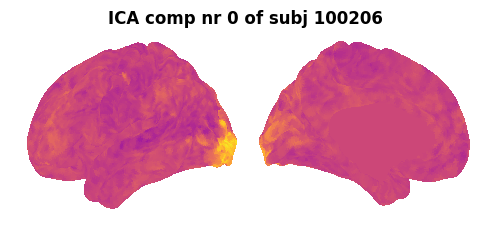

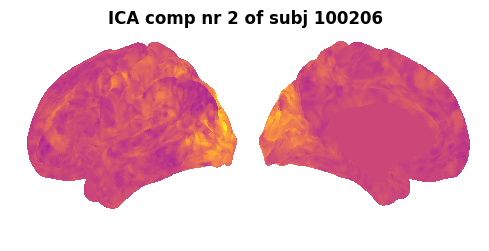

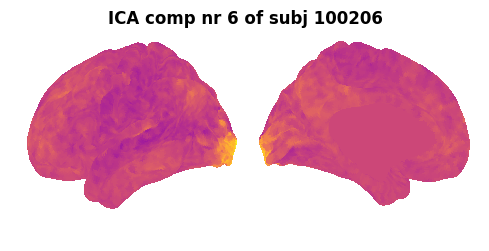

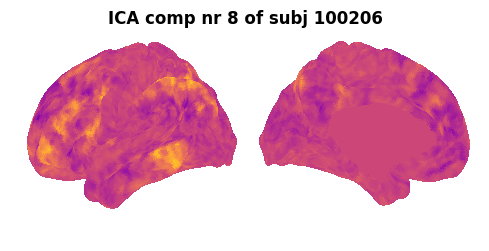

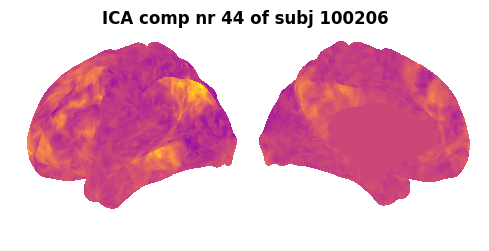

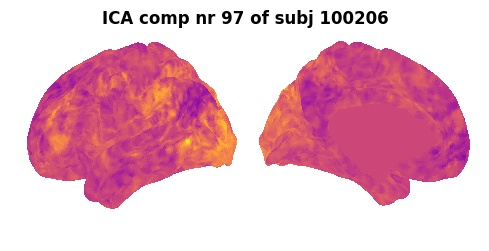

In [14]:
from lib.plotting import plot_29k

for mn in [1,3, 7, 9, 45, 98]:
  plot_29k(lh_subj_conn[:, mn-1], cmap="plasma", title=f"ICA comp nr {mn-1} of subj {subj}", colorbar=None)


## batch generation

In [22]:
#!mkdir /scratch/users/robert.scholz2/hcp/rsfc_NodeTS_Ica200v2

n_ica_comps = 200;
rsfc_dir = "/scratch/users/robert.scholz2/hcp/rsfc_NodeTS_Ica200v2"
dirn = "/scratch/users/robert.scholz2/HCP_Resources/GroupAvg/HCP_PTN1200"

# Full loop
for sn, subj in tqdm(enumerate(all_subjs), desc="Calc subj connectivtiy mats", total=len(all_subjs)):
  
  subj_rsfc_file = os.path.join(rsfc_dir, f"L_{subj}_fullts_rsfc_icav2.npy")
  if os.path.exists(subj_rsfc_file):
    print(f"Skipping subject {subj} as the connectivity mat samples already seem to exist")
    continue;
  
  lh_full_ts = np.concatenate([load_hcp_ts_data("/scratch/users/robert.scholz2/"+ rs_file_stub, subj, session, zscore=True) for session in sessions], axis=0).T
  # lh_full_ts of shape (29696, 4800)
  
  subj_node_ts_file = f"{dirn}/node_timeseries/3T_HCP1200_MSMAll_d{n_ica_comps}_ts2/{subj}.txt"
  subj_node_ts = np.genfromtxt(subj_node_ts_file).T # of shape (200, 4800) ~ 50-200 parcels, 4800 timepoints
  
  ts = slice(None)
  lh_subj_conn = compute_corr_coeff(lh_full_ts[:, ts], subj_node_ts[:, ts])
  # resulting shape: (29696, 200)
  
  #subj_rsfc_conn = np.concatenate((lh_subj_conn.T, rh_subj_conn.T))
  print("Saving:", subj_rsfc_file);
  np.save(subj_rsfc_file, lh_subj_conn.T)
  clear_output(wait=True)

Calc subj connectivtiy mats: 100%|██████████| 254/254 [45:57<00:00, 10.85s/it]


In [23]:
# Loading all the individual ICA components into a single data strcuture
all_icamaps = {}

for sn, subj in tqdm(enumerate(all_subjs), desc="Load data", total=len(all_subjs)):
  subj_rsfc_file = os.path.join(rsfc_dir, f"L_{subj}_fullts_rsfc_icav2.npy")
  data = np.load(subj_rsfc_file)
  all_icamaps[subj] = data.astype(np.float32).T;

len(all_icamaps.keys())

Load data: 100%|██████████| 254/254 [00:35<00:00,  7.11it/s]


254

In [27]:
# saving this data structure
fn = "/scratch/users/robert.scholz2/acc_dists/all_ICAmapsV2_254_full_unrelated.L.c200.npy"
np.save(fn, all_icamaps)
!ls -ash {fn}

5.7G /scratch/users/robert.scholz2/acc_dists/all_ICAmapsV2_254_full_unrelated.L.c200.npy


In [33]:
# Delete individual component files to save space
for sn, subj in tqdm(enumerate(all_subjs), desc="Deleting tempoary data", total=len(all_subjs)):
  os.remove(os.path.join(rsfc_dir, f"L_{subj}_fullts_rsfc_icav2.npy"))

Deleting tempoary data:   0%|          | 0/254 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/users/robert.scholz2/hcp/rsfc_NodeTS_Ica200v2/L_100206_fullts_rsfc_icav2.npy'

# BrainSurfCNN: Generate subject connectivty mat samples and concat task contrasts

In [ ]:
# function to load the 4 resting state time series

def load_ts_data(file_path, subj, session, v=False, bma_slice=slice(0, 29696, None), zscore=False):
  file_path = file_path.format(**{"session":session, "subj" : subj})
  if v: print(file_path)
  nimg = nib.load(file_path)
  fsdata = nimg.get_fdata()[:, bma_slice]
  # somehow expand to 32k????
  return zscaler.fit_transform(fsdata) if zscore else fsdata;

subj = all_subjs[0]
lh_full_ts = np.concatenate([load_ts_data("/scratch/users/robert.scholz2/"+rs_file_stub, subj, session) for session in sessions], axis=0)
lh_full_ts.shape

In [ ]:
# Sample calculation
print(subj)
num_samples = 8;
sample_length = 4800//num_samples #lh_full_ts.shape[0]// num_samples = 600
print(sample_length)

# #...REST1_RL, REST2_LR, REST2_RL
lh_full_ts = np.concatenate([ load_ts_data("/scratch/users/robert.scholz2/"+ \
    rs_file_stub, subj, session) for session in sessions], axis=0).T
subj_node_ts_file = f"{dirn}/node_timeseries/3T_HCP1200_MSMAll_d50_ts2/{subj}.txt"
subj_node_ts = np.genfromtxt(subj_node_ts_file).T # of shape (50, 4800) ~ 50 parcels, 4800 timepoints
print(lh_full_ts.shape, subj_node_ts.shape)
i = 0
ts = np.arange(i*sample_length, (i+1)*sample_length)
lh_subj_conn = compute_corr_coeff(lh_full_ts[:, ts], subj_node_ts[:, ts])
lh_subj_conn.shape

In [ ]:
# full loop
num_samples = 8;

rsfc_dir = "/scratch/users/robert.scholz2/hcp/rsfc_NodeTS_Ica50"
node_ts_archive_file = '/scratch/users/robert.scholz2/HCP_Resources/GroupAvg/HCP_PTN1200/NodeTimeseries_3T_HCP1200_MSMAll_ICAd50_ts2.tar.gz'
dirn = os.path.dirname(node_ts_archive_file)
sample_length = 4800//num_samples #lh_full_ts.shape[0]// num_samples = 600


for sn, subj in tqdm(enumerate(all_subjs), desc="Calc subj connectivtiy mats", total=len(all_subjs)):
  
  if os.path.exists(os.path.join(rsfc_dir, f"L_{subj}_sample0_rsfc.npy")):
    print(f"Skipping subject {subj} as the connectivity mat samples already seem to exist")
    continue;
    
  print("");

  lh_full_ts = np.concatenate([ load_ts_data("/scratch/users/robert.scholz2/"+ \
                                rs_file_stub, subj, session) for session in sessions], axis=0).T
  # lh_full_ts of shape (29696, 4800)
  
  subj_node_ts_file = f"{dirn}/node_timeseries/3T_HCP1200_MSMAll_d50_ts2/{subj}.txt"
  subj_node_ts = np.genfromtxt(subj_node_ts_file).T # of shape (50, 4800) ~ 50 parcels, 4800 timepoints
  
  for i in range(num_samples):
    ts = np.arange(i*sample_length, (i+1)*sample_length)
    lh_subj_conn = compute_corr_coeff(lh_full_ts[:, ts], subj_node_ts[:, ts]) # -> shape (29696, 50)
    subj_rsfc_file = os.path.join(rsfc_dir, f"L_{subj}_sample{i}_rsfc.npy")
    #subj_rsfc_conn = np.concatenate((lh_subj_conn.T, rh_subj_conn.T)) # shape (100, 29696)
    print("Saving:", subj_rsfc_file);
    np.save(subj_rsfc_file, lh_subj_conn.T)
    
  clear_output(wait=True)